In [3]:
import os
import shutil
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Paths
DATA_DIR = "/kaggle/input/graddataset"  # Original dataset directory
TRAIN_DIR = "/kaggle/working/train_data"  # Training dataset directory
TEST_DIR = "/kaggle/working/test_data"  # Testing dataset directory
IMG_SIZE = (224, 224)  # Required for MobileNet
BATCH_SIZE = 16
EPOCHS = 13
MAX_IMAGES_PER_CLASS = 16000  # Limit to 16k images per class

In [5]:
def prepare_dataset(data_dir, train_dir, test_dir, max_images_per_class, train_split=0.8):
    # Clear existing directories
    for dir_path in [train_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path, exist_ok=True)

    # Process each class
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            # Limit images to max_images_per_class
            images = os.listdir(class_path)[:max_images_per_class]
            train_images, test_images = train_test_split(images, train_size=train_split, random_state=42)

            # Create class directories in train and test folders
            train_class_dir = os.path.join(train_dir, class_name)
            test_class_dir = os.path.join(test_dir, class_name)
            os.makedirs(train_class_dir, exist_ok=True)
            os.makedirs(test_class_dir, exist_ok=True)

            # Copy images to train and test directories
            for image in train_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(train_class_dir, image))
            for image in test_images:
                shutil.copy(os.path.join(class_path, image), os.path.join(test_class_dir, image))


In [6]:
prepare_dataset(DATA_DIR, TRAIN_DIR, TEST_DIR, MAX_IMAGES_PER_CLASS)

# Step 2: Data Augmentation and Generators
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [7]:
train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 46665 images belonging to 4 classes.


In [8]:
test_gen = datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Disable shuffle for consistent evaluation
)

Found 11666 images belonging to 4 classes.


In [9]:
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))

# Fine-tune layers
for layer in base_model.layers[:-10]:  # Freeze all but the last 10 layers
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.4)(x)
predictions = Dense(train_gen.num_classes, activation='softmax')(x)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model = Model(inputs=base_model.input, outputs=predictions)

# Step 4: Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
checkpoint = ModelCheckpoint(
    filepath=os.path.join("/kaggle/working", "mobilenet_model_epoch_{epoch:02d}.keras"),
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'
)

In [12]:
csv_logger = CSVLogger(os.path.join("/kaggle/working", 'training_log.csv'))

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [13]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, csv_logger, lr_scheduler]
)

Epoch 1/13


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2917/2917 ━━━━━━━━━━━━━━━━━━━━ 742s 250ms/step - accuracy: 0.6420 - loss: 7.9270 - val_accuracy: 0.7604 - val_loss: 2.2266 - learning_rate: 1.0000e-04
Epoch 2/13
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 717s 245ms/step - accuracy: 0.7849 - loss: 1.6533 - val_accuracy: 0.7646 - val_loss: 0.8905 - learning_rate: 1.0000e-04
Epoch 3/13
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 721s 247ms/step - accuracy: 0.8145 - loss: 0.7109 - val_accuracy: 0.7844 - val_loss: 0.6551 - learning_rate: 1.0000e-04
Epoch 4/13
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 708s 242ms/step - accuracy: 0.8368 - loss: 0.5212 - val_accuracy: 0.8077 - val_loss: 0.5771 - learning_rate: 1.0000e-04
Epoch 5/13
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 712s 244ms/step - accuracy: 0.8469 - loss: 0.4675 - val_accuracy: 0.8420 - val_loss: 0.4838 - learning_rate: 1.0000e-04
Epoch 6/13
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 715s 245ms/step - accuracy: 0.8594 - loss: 0.4274 - val_accuracy: 0.8505 - val_loss: 0.4446 - learning_rate: 1.0000e-04
Epoch 7/13
2917/2917 ━━━━━━━━━━━━━━━━━━

In [14]:
model.save(os.path.join("/kaggle/working", "mobilenet_final_model.keras"))

# Step 7: Evaluate the Model
test_gen.reset()
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test Accuracy: {test_accuracy:.2f}")

730/730 ━━━━━━━━━━━━━━━━━━━━ 142s 194ms/step - accuracy: 0.8101 - loss: 0.4781
Test Accuracy: 0.88


In [15]:
# Step 8: Generate Confusion Matrix and Classification Report
test_gen.reset()
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

730/730 ━━━━━━━━━━━━━━━━━━━━ 142s 193ms/step


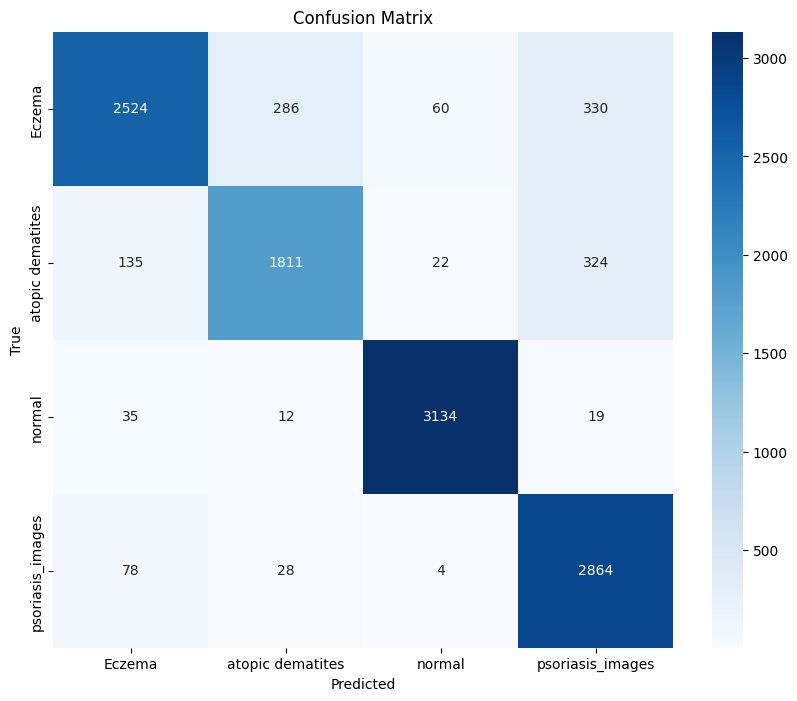

In [16]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=train_gen.class_indices.keys(), yticklabels=train_gen.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [17]:
# Classification Report
print(classification_report(y_true, y_pred, target_names=train_gen.class_indices.keys()))

                  precision    recall  f1-score   support

          Eczema       0.91      0.79      0.85      3200
atopic dematites       0.85      0.79      0.82      2292
          normal       0.97      0.98      0.98      3200
psoriasis_images       0.81      0.96      0.88      2974

        accuracy                           0.89     11666
       macro avg       0.89      0.88      0.88     11666
    weighted avg       0.89      0.89      0.88     11666

